# Object Detection Demo

# Imports

In [2]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

In [3]:
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [4]:
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

# Model preparation 

In [8]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = "../jobs/sample_job/train_out/ssd_mobilenet_v1/exported_graph/frozen_inference_graph.pb"

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = "../jobs/sample_job/data/label_map.pbtxt"

NUM_CLASSES = 2

## Load a (frozen) Tensorflow model into memory.

In [9]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [10]:
detection_graph.get_operations()

[<tf.Operation 'Const' type=Const>,
 <tf.Operation 'image_tensor' type=Placeholder>,
 <tf.Operation 'ToFloat' type=Cast>,
 <tf.Operation 'Preprocessor/map/Shape' type=Shape>,
 <tf.Operation 'Preprocessor/map/strided_slice/stack' type=Const>,
 <tf.Operation 'Preprocessor/map/strided_slice/stack_1' type=Const>,
 <tf.Operation 'Preprocessor/map/strided_slice/stack_2' type=Const>,
 <tf.Operation 'Preprocessor/map/strided_slice' type=StridedSlice>,
 <tf.Operation 'Preprocessor/map/TensorArray' type=TensorArrayV3>,
 <tf.Operation 'Preprocessor/map/TensorArrayUnstack/Shape' type=Shape>,
 <tf.Operation 'Preprocessor/map/TensorArrayUnstack/strided_slice/stack' type=Const>,
 <tf.Operation 'Preprocessor/map/TensorArrayUnstack/strided_slice/stack_1' type=Const>,
 <tf.Operation 'Preprocessor/map/TensorArrayUnstack/strided_slice/stack_2' type=Const>,
 <tf.Operation 'Preprocessor/map/TensorArrayUnstack/strided_slice' type=StridedSlice>,
 <tf.Operation 'Preprocessor/map/TensorArrayUnstack/range/start'

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [11]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [12]:
category_index

{1: {'id': 1, 'name': 'ship'}, 2: {'id': 2, 'name': 'batea'}}

/home/diglesia/miniconda2/envs/tensorflow/lib/python3.5/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


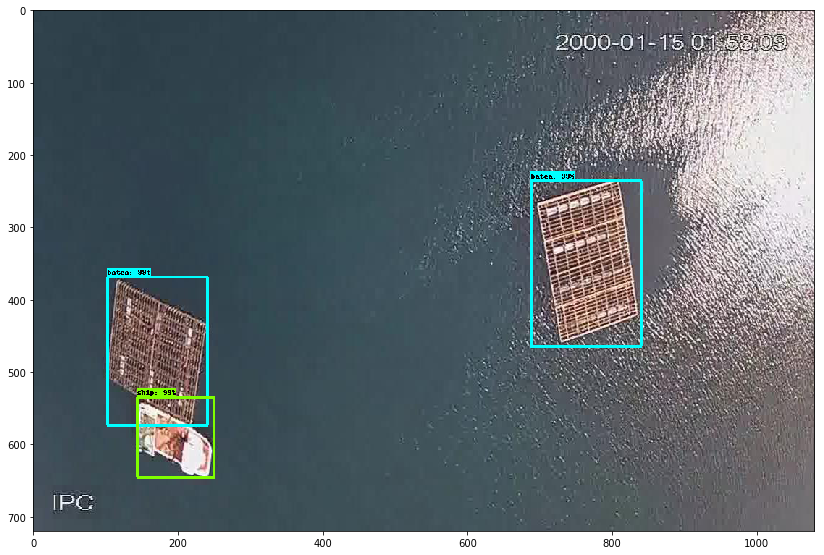

In [13]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:

        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    
        image = Image.open("/home/diglesia/Escritorio/dataset_ship_batea/train/2image-243.jpeg")
        image = image.resize((1080, 720))
        image_np = np.array(image)
    
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
    
        # Actual detection.
        (boxes, scores, classes) = sess.run(
          [detection_boxes, detection_scores, detection_classes],
          feed_dict={image_tensor: image_np_expanded})

        # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=4)
    
        plt.figure(figsize=(14, 14))
        plt.imshow(image_np)

# Boxes

In [20]:
boxes[0][:4]

array([[ 0.51356024,  0.09445971,  0.79620904,  0.22347245],
       [ 0.32786024,  0.63676929,  0.64533317,  0.77827549],
       [ 0.74405926,  0.13241632,  0.89669377,  0.23188071],
       [ 0.01711977,  0.9433924 ,  0.04510644,  0.96417069]], dtype=float32)

# Scores

In [19]:
scores[0][:4]

array([ 0.99999607,  0.99999166,  0.99956542,  0.02794205], dtype=float32)

# Classes

In [21]:
classes[0][:4]

array([ 2.,  2.,  1.,  1.], dtype=float32)

# Crop first box

In [24]:
category_index[classes[0][0]]

{'id': 2, 'name': 'batea'}

In [22]:
xmin = int(boxes[0][0][0] * image.size[1])
xmax = int(boxes[0][0][2] * image.size[1])
ymin = int(boxes[0][0][1] * image.size[0])
ymax = int(boxes[0][0][3] * image.size[0])

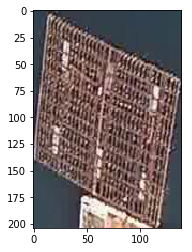

In [23]:
plt.imshow(np.array(image)[xmin:xmax, ymin:ymax])